In [2]:
#import libraries
import os
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten,concatenate,GlobalAveragePooling2D, Reshape, Dense, multiply, Lambda, Dropout, MultiHeadAttention
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf

In [3]:
# Data preparation
dataset_dir= r'PlantVillage'
input_shape=(224, 224, 3)
batch_size=4
num_classes=3

In [4]:
#Data augmentation
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [5]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

#Generate the train dataset, validation dataset and test dataset
train_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=False,
    subset='validation')

test_generator=test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical' 
)

Found 8665 images belonging to 3 classes.
Found 2165 images belonging to 3 classes.
Found 10831 images belonging to 3 classes.


In [6]:
def custom_loss(y_true, y_pred):
    # Avoid dividing by zero and add a small constant
    epsilon = 1e-15
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    # Calculate categorical cross entropy loss
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred + 1e-9)) / tf.cast(tf.shape(y_true)[0], dtype=tf.float32)

    return loss

In [6]:
def create_model1(inputs):
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
   #Add self-attention mechanism
    attention_output = MultiHeadAttention(num_heads=8, key_dim=16)(pool2, pool2)
    attention_output = GlobalAveragePooling2D()(attention_output)
    
    model = Model(inputs=inputs, outputs=attention_output)
    return model

In [7]:
def create_model2(inputs):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    x = GlobalAveragePooling2D()(pool2)
    model = Model(inputs=inputs, outputs=x)
    
    return model

In [8]:
def create_ensemble_model(input_shape):
    input_layer = Input(shape=input_shape)

    model1 = create_model1(input_layer)
    model2 = create_model2(input_layer)
    
    # Combine the adjusted attention-applied output and model2
    merged = concatenate([model1.output, model2.output])

    output_layer = Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [9]:
# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 3

In [10]:
# Create the ensemble model
ensemble_model = create_ensemble_model(input_shape)

ensemble_model.summary()

2023-12-03 17:02:12.472605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                           

2023-12-03 17:02:13.007112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c1:00.0, compute capability: 8.6


In [11]:
# Compile and train the ensemble model
ensemble_model.compile(loss=custom_loss, optimizer='adam', metrics=['accuracy'])

In [12]:
#Train the model
history=ensemble_model.fit(train_generator, epochs=5, validation_data=(validation_generator), verbose=1)

Epoch 1/5


2023-12-03 17:02:15.239392: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-03 17:02:16.666376: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2167/2167 [==============================] - 169s 76ms/step - loss: 0.8372 - accuracy: 0.6250 - val_loss: 0.6989 - val_accuracy: 0.7035
Epoch 2/5
2167/2167 [==============================] - 163s 75ms/step - loss: 0.4750 - accuracy: 0.8174 - val_loss: 0.3129 - val_accuracy: 0.8859
Epoch 3/5
2167/2167 [==============================] - 164s 76ms/step - loss: 0.3776 - accuracy: 0.8571 - val_loss: 0.3409 - val_accuracy: 0.8734
Epoch 4/5
2167/2167 [==============================] - 163s 75ms/step - loss: 0.3229 - accuracy: 0.8809 - val_loss: 0.2957 - val_accuracy: 0.8887
Epoch 5/5
2167/2167 [==============================] - 163s 75ms/step - loss: 0.2620 - accuracy: 0.9029 - val_loss: 0.2485 - val_accuracy: 0.9155


In [13]:
from tensorflow.keras.models import load_model

# save model
model_save_path = r'my_model.h5'

try:
    ensemble_model.save(model_save_path)
    print(f"Model saved successfully at: {model_save_path}")
except Exception as e:
    print(f"Error saving model: {e}")

Model saved successfully at: my_model.h5


In [7]:
from tensorflow.keras.models import load_model
loaded_model = load_model('my_model.h5', custom_objects={'custom_loss': custom_loss})

2023-12-03 18:40:57.507110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 18:40:58.054625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c1:00.0, compute capability: 8.6


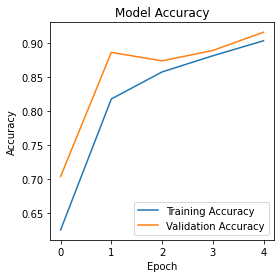

In [15]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(4,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')
plt.show()

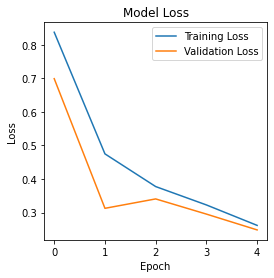

In [16]:
#Trainig loss and validation loss graph
plt.figure(figsize=(4,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')
plt.show()

In [17]:
#Performance on test set
test_loss, test_acc = ensemble_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

2708/2708 [==============================] - 83s 31ms/step - loss: 0.2098 - accuracy: 0.9304
Test loss: 0.20978926122188568
Test accuracy: 0.9303849935531616


In [8]:
# Get the prediction results of the model
y_pred = loaded_model.predict(test_generator)
y_true = test_generator.classes

2023-12-03 18:41:11.352680: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


   8/2708 [..............................] - ETA: 1:10

2023-12-03 18:41:12.872612: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2708/2708 [==============================] - 79s 28ms/step


Confusion Matrix:
[[2413   55    8]
 [ 218 1742  192]
 [ 191   90 5922]]


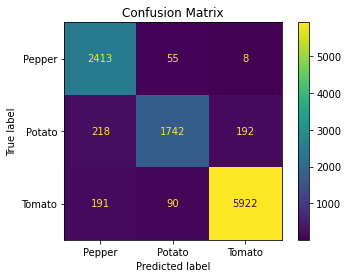

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert probabilities to categories
y_pred_labels = np.argmax(y_pred, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred_labels)

print("Confusion Matrix:")
print(confusion)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=class_labels)
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Import necessary libraries
from sklearn.metrics import f1_score

# Assuming y_true and y_pred_labels are defined

# Compute the F1 score (micro)
f1_micro = f1_score(y_true, y_pred_labels, average='micro')
print('F1-score (micro):', f1_micro)

# Compute the F1 score (macro)
f1_macro = f1_score(y_true, y_pred_labels, average='macro')
print('F1-score (macro):', f1_macro)

# Compute the F1 score (weighted)
f1_weighted = f1_score(y_true, y_pred_labels, average='weighted')
print('F1-score (weighted):', f1_weighted)

F1-score (micro): 0.9303850060012926
F1-score (macro): 0.9114910526813965
F1-score (weighted): 0.9299810896913491


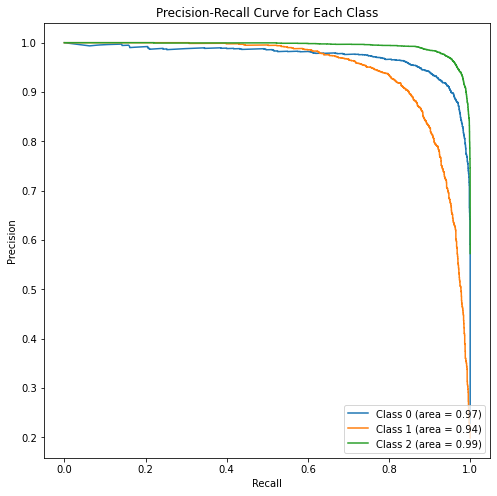

In [11]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarize multi-category labels
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  # 0, 1, 2是你的类别标签

#Initialize drawing
plt.figure(figsize=(8, 8))

# Calculate precision-recall curve for each category
for i in range(y_true_bin.shape[1]):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label='Class {} (area = {:0.2f})'.format(i, pr_auc))

# Draw legends, labels, etc.
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='lower right')
plt.show()


In [12]:

# Initialize variables to store overall sensitivity and specificity
overall_sensitivity = 0
overall_specificity = 0

# Loop through each class
for i, class_label in enumerate(class_labels):
    # Extract TP, FP, FN, and TN for the current class
    TP = confusion[i, i]
    FP = sum(confusion[:, i]) - TP
    FN = sum(confusion[i, :]) - TP
    TN = sum(sum(confusion)) - TP - FP - FN
    
    # Compute sensitivity and specificity for the current class
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    # Print or store sensitivity and specificity for the current class
    print(f'Class {class_label} Sensitivity: {sensitivity:.4f}')
    print(f'Class {class_label} Specificity: {specificity:.4f}')
    
    # Accumulate sensitivity and specificity for overall calculation
    overall_sensitivity += sensitivity
    overall_specificity += specificity

# Calculate overall sensitivity and specificity
num_classes = len(class_labels)
overall_sensitivity /= num_classes
overall_specificity /= num_classes

# Print or store overall sensitivity and specificity
print(f'Overall Sensitivity: {overall_sensitivity:.4f}')
print(f'Overall Specificity: {overall_specificity:.4f}')


Class Pepper Sensitivity: 0.9746
Class Pepper Specificity: 0.9510
Class Potato Sensitivity: 0.8095
Class Potato Specificity: 0.9833
Class Tomato Sensitivity: 0.9547
Class Tomato Specificity: 0.9568
Overall Sensitivity: 0.9129
Overall Specificity: 0.9637


In [23]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del ensemble_model

In [24]:
from numba import cuda

cuda.select_device(0)
cuda.close()